In [12]:
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.fftpack import idct, dct

from uncond_ts_diff.custom_dataset import get_custom_dataset

In [13]:
from gbm import estimate_parameters

In [14]:
plt.style.use('seaborn')

/tmp/ipykernel_5016/2955780531.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [15]:
def plot_gbm(St, n, M, dt, xlabel="Years $(t)$", ylabel="Stock Price $(S_t)$"):
    time = np.linspace(0, n * dt, St.shape[0])
    tt = np.full(shape=(M, St.shape[0]), fill_value=time).T
    plt.plot(tt, St)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_freq(St, n, M, dt):
    time = np.linspace(0, n * dt, St.shape[0])
    tt = np.full(shape=(M, St.shape[0]), fill_value=time).T
    plt.plot(tt, St)
    plt.xlabel("Frequency $(f)$")
    plt.ylabel("Magnitude")
    plt.show()


In [16]:
def reverse_log_returns(log_returns, s0):
    """
    Reconstructs the price series from log returns.
    
    Parameters:
    - log_returns: The log returns series (2D array).
    - s0: The initial price (float or array).
    
    Returns:
    - Reconstructed price series.
    """
    # Initialize the price array
    M = log_returns.shape[1]  # Number of paths
    n = log_returns.shape[0] + 1  # Number of time steps, including the initial price
    reconstructed_prices = np.zeros((n, M))
    
    # Set the initial prices
    reconstructed_prices[0, :] = s0
    
    # Rebuild prices from log returns
    for i in range(1, n):
        reconstructed_prices[i, :] = reconstructed_prices[i-1, :] * np.exp(log_returns[i-1, :])

    return reconstructed_prices


In [17]:
from statsmodels.graphics.tsaplots import plot_acf

def analyze_log_returns(real, synth):
    """
    Analyzes the distribution (using KDE), mean, variance, and autocorrelation function (ACF)
    of a matrix of log returns.
    
    Parameters:
    log_returns (np.ndarray): A matrix of log returns with shape (timesteps, paths)
    
    Returns:
    None
    """
    
    # 1. Plotting the KDE (distribution) of log returns
    plt.figure(figsize=(10, 6))
    sns.kdeplot(real.flatten(), fill=True, label='Real')
    sns.kdeplot(synth.flatten(), fill=True, label='Synth')
    plt.title('KDE Plot of Log Returns')
    plt.xlabel('Log Return')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()

    # # 2. Mean and variance of log returns
    # mean_log_returns = np.mean(log_returns, axis=1)
    # variance_log_returns = np.var(log_returns, axis=1)

    # # Plotting the mean of log returns over time
    # plt.figure(figsize=(10, 6))
    # plt.plot(mean_log_returns, label='Mean Log Returns', color='blue')
    # plt.title('Mean Log Returns Over Time')
    # plt.xlabel('Timestep')
    # plt.ylabel('Mean Log Return')
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    # # Plotting the variance of log returns over time
    # plt.figure(figsize=(10, 6))
    # plt.plot(variance_log_returns, label='Variance of Log Returns', color='red')
    # plt.title('Variance of Log Returns Over Time')
    # plt.xlabel('Timestep')
    # plt.ylabel('Variance')
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    # # 3. Autocorrelation function (ACF) of the average log returns
    # plt.figure(figsize=(10, 6))
    # plot_acf(mean_log_returns, lags=40)
    # plt.title('Autocorrelation of Mean Log Returns')
    # plt.show()


real size:  (197, 10000)
synth size:  (197, 10000)
Log returns:


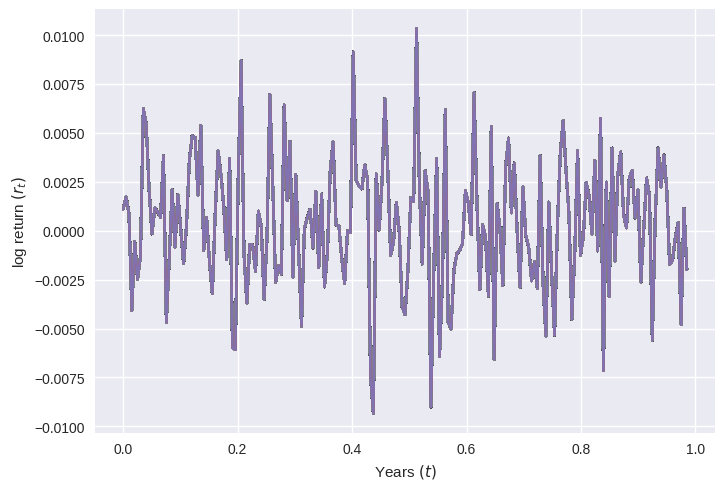

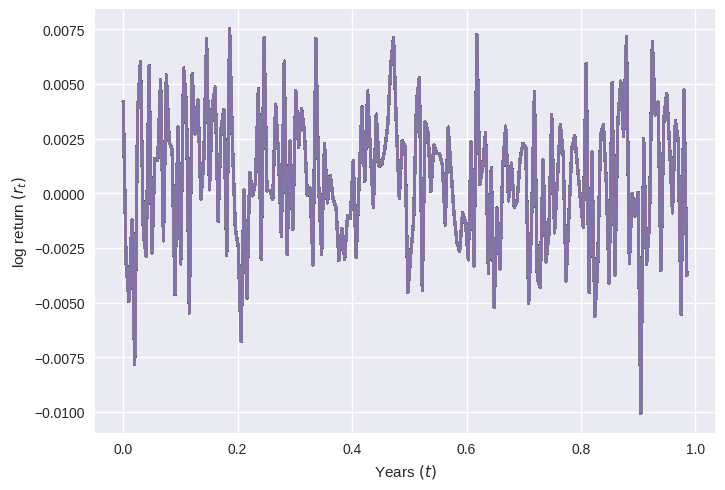

Log returns distribution:


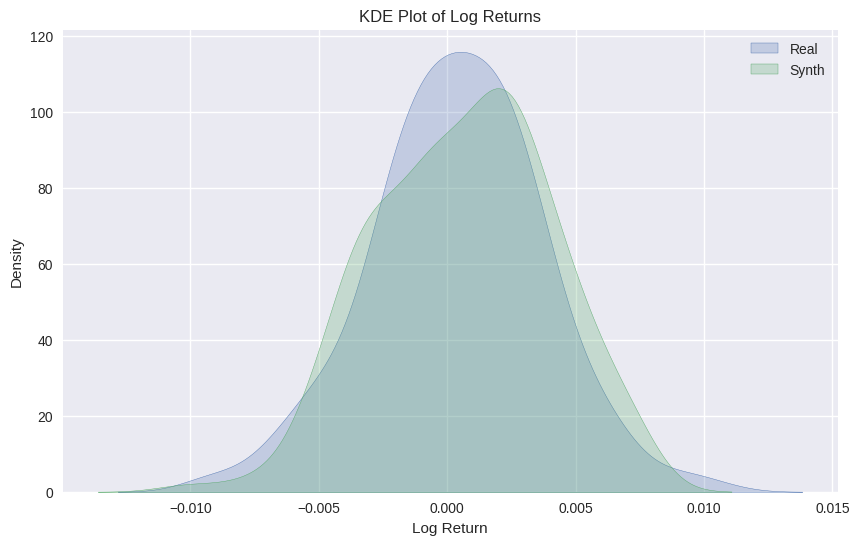

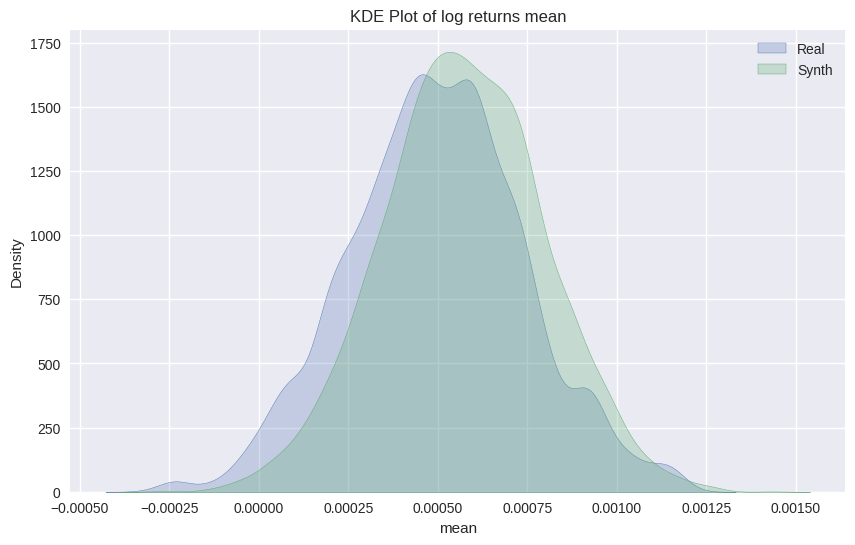

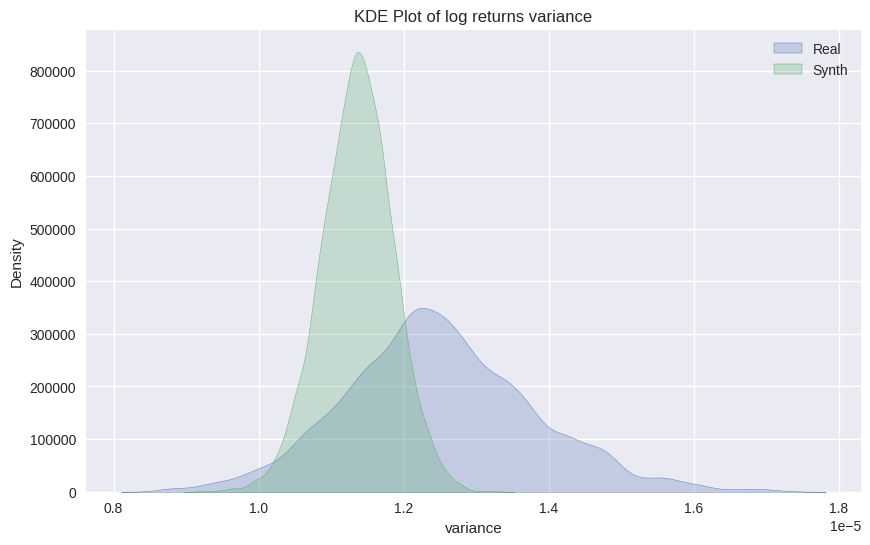

<Figure size 1000x600 with 0 Axes>

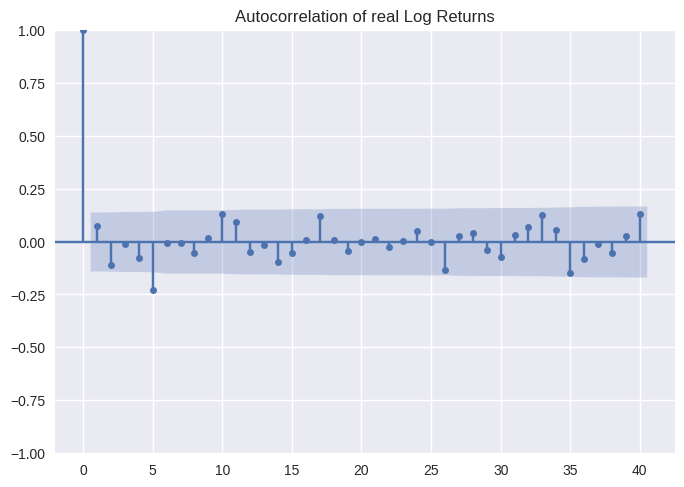

<Figure size 1000x600 with 0 Axes>

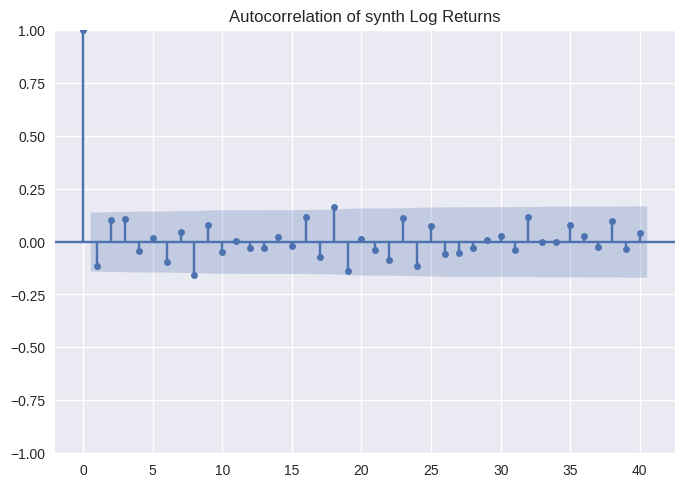

GBM:


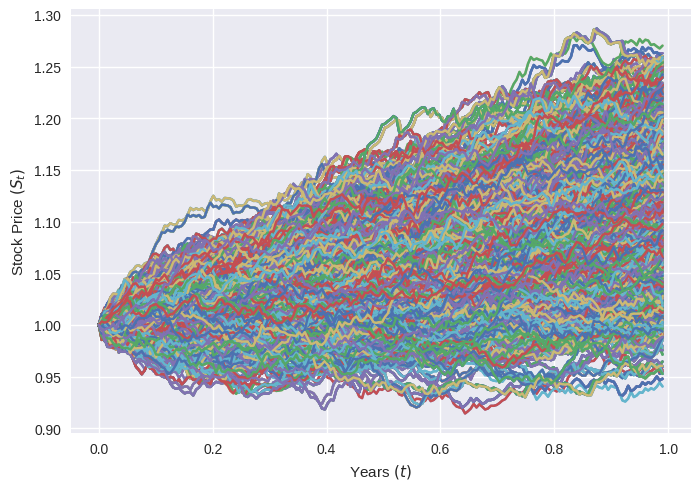

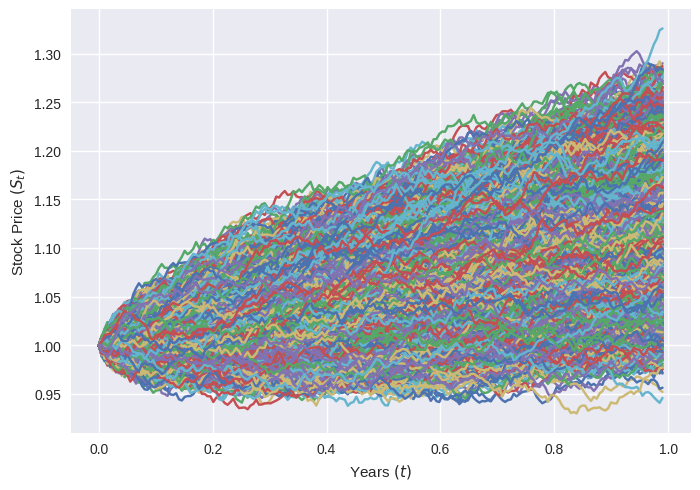

Mu, Sigma estimations:


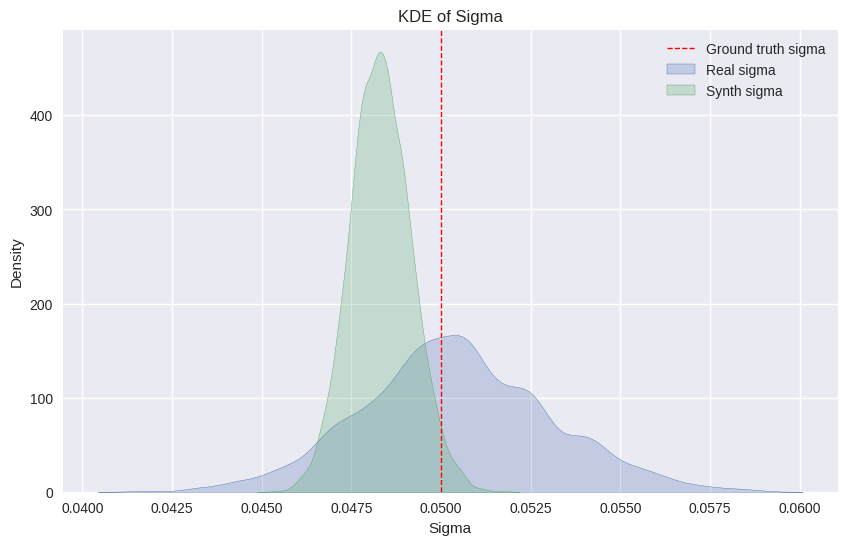

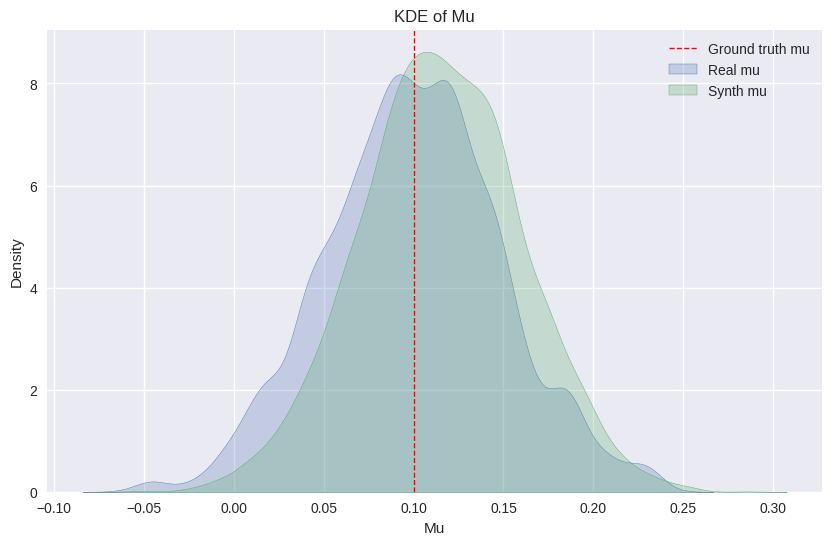

----------------------------------------------------------------------------------------------------


In [18]:
prediction_length = 1
n = 200
EXP_NAME = 'exp18'
DATASET = 'log-return'



gbm_path = f'../results/{EXP_NAME}/{DATASET}/generation_log-0/'
data_path = gbm_path
real = np.load(data_path + 'real_samples.npy').T
synth = np.load(data_path + 'synth_samples.npy').T
# dataset = get_custom_dataset(f"../data/{EXP_NAME}/gbm-{i}.jsonl", 'D', prediction_length)
gt_params = json.load(open(f"../data/{EXP_NAME}/gbm-{0}-params.json"))
gt_mu = gt_params['gbm_parameters']['mu']
gt_sigma = gt_params['gbm_parameters']['sigma']
# st = np.array([item['target'] for item in list(dataset.train)]).T
# st_params = estimate_parameters(st, 1/n, ret_distribution=True)
# print('st size: ', st.shape)
print('real size: ', real.shape)
print('synth size: ', synth.shape)

scale = np.mean(
        np.abs(real[..., : -prediction_length]),
        axis=-1,
        keepdims=True,
    )
# real = real/scale
synth = synth*scale

# plot_gbm(st[:, 10], st.shape[0], st.shape[1], 1/n)
print("Log returns:")
plot_gbm(real[:, 10], real.shape[0], real.shape[1], 1/n, ylabel="log return $(r_t)$")
plot_gbm(synth[:, 10], synth.shape[0], synth.shape[1], 1/n, ylabel="log return $(r_t)$")

print("Log returns distribution:")
analyze_log_returns(real[:, 10], synth[:, 10])
real_mean = np.mean(real, axis=0)
synth_mean = np.mean(synth, axis=0)
plt.figure(figsize=(10, 6))
sns.kdeplot(real_mean.flatten(), fill=True, label='Real')
sns.kdeplot(synth_mean.flatten(), fill=True, label='Synth')
plt.title('KDE Plot of log returns mean')
plt.xlabel('mean')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

real_mean = np.var(real, axis=0)
synth_mean = np.var(synth, axis=0)
plt.figure(figsize=(10, 6))
sns.kdeplot(real_mean.flatten(), fill=True, label='Real')
sns.kdeplot(synth_mean.flatten(), fill=True, label='Synth')
plt.title('KDE Plot of log returns variance')
plt.xlabel('variance')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show() 


plt.figure(figsize=(10, 6))
plot_acf(real[:, 10], lags=40)
plt.title('Autocorrelation of real Log Returns')
plt.show()

plt.figure(figsize=(10, 6))
plot_acf(synth[:, 10], lags=40)
plt.title('Autocorrelation of synth Log Returns')
plt.show() 

real = reverse_log_returns(real, 1)
synth = reverse_log_returns(synth, 1)

print("GBM:")
plot_gbm(real, real.shape[0], real.shape[1], 1/n)
plot_gbm(synth, synth.shape[0], synth.shape[1], 1/n)

real_params = estimate_parameters(real, 1/n, ret_distribution=True)
synth_params = estimate_parameters(synth, 1/n, ret_distribution=True)

print("Mu, Sigma estimations:")
# Create a new figure for the KDE plots of sigma
plt.figure(figsize=(10, 6))
plt.axvline(gt_sigma, color='r', label='Ground truth sigma', linestyle='dashed', linewidth=1)
sns.kdeplot(real_params[0], label='Real sigma', fill=True)
sns.kdeplot(synth_params[0], label='Synth sigma', fill=True)
# sns.kdeplot(real_params[0], label='Real(sampled) sigma', fill=True)
plt.title('KDE of Sigma')
plt.xlabel('Sigma')
plt.ylabel('Density')
plt.legend()
plt.show()

# Create a new figure for the KDE plots of mu
plt.figure(figsize=(10, 6))
plt.axvline(gt_mu, color='r', label='Ground truth mu', linestyle='dashed', linewidth=1)
sns.kdeplot(real_params[1], label='Real mu', fill=True)
sns.kdeplot(synth_params[1], label='Synth mu', fill=True)
# sns.kdeplot(real_params[1], label='Real(sampled) mu', fill=True)
plt.title('KDE of Mu')
plt.xlabel('Mu')
plt.ylabel('Density')
plt.legend()
plt.show()

print('-' * 100)
    
    
    

    


In [19]:
prediction_length = 1
n = 200
nums_of_datasets = 2
EXP_NAME = 'exp12'



for i in range(nums_of_datasets):
    gbm_path = f'../results/{EXP_NAME}/generation_log-{i+2}/'
    data_path = gbm_path
    real = np.load(data_path + 'real_samples.npy').T
    synth = np.load(data_path + 'synth_samples.npy').T
    dataset = get_custom_dataset(f"../data/{EXP_NAME}/gbm-{i}.jsonl", 'D', prediction_length)
    gt_params = json.load(open(f"../data/{EXP_NAME}/gbm-{i}-params.json"))
    gt_mu = gt_params['gbm_parameters']['mu']
    gt_sigma = gt_params['gbm_parameters']['sigma']
    st = np.array([item['target'] for item in list(dataset.train)]).T
    st_params = estimate_parameters(st, 1/n, ret_distribution=True)
    print('st size: ', st.shape)
    print('real size: ', real.shape)
    print('synth size: ', synth.shape)
    
    scale = np.mean(
            np.abs(real[..., : -prediction_length]),
            axis=-1,
            keepdims=True,
        )
    # real = real/scale
    synth = synth*scale
    
    plot_gbm(st[:, 10], st.shape[0], st.shape[1], 1/n)
    print("Log returns:")
    plot_gbm(real[:, 10], real.shape[0], real.shape[1], 1/n, ylabel="log return $(r_t)$")
    plot_gbm(synth[:, 10], synth.shape[0], synth.shape[1], 1/n, ylabel="log return $(r_t)$")
    
    print("Log returns distribution:")
    analyze_log_returns(real[:, 10], synth[:, 10])
    real_mean = np.mean(real, axis=0)
    synth_mean = np.mean(synth, axis=0)
    plt.figure(figsize=(10, 6))
    sns.kdeplot(real_mean.flatten(), fill=True, label='Real')
    sns.kdeplot(synth_mean.flatten(), fill=True, label='Synth')
    plt.title('KDE Plot of log returns mean')
    plt.xlabel('mean')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    real_mean = np.var(real, axis=0)
    synth_mean = np.var(synth, axis=0)
    plt.figure(figsize=(10, 6))
    sns.kdeplot(real_mean.flatten(), fill=True, label='Real')
    sns.kdeplot(synth_mean.flatten(), fill=True, label='Synth')
    plt.title('KDE Plot of log returns variance')
    plt.xlabel('variance')
    plt.ylabel('Density')
    plt.grid(True)
    plt.legend()
    plt.show() 
    
    
    plt.figure(figsize=(10, 6))
    plot_acf(real[:, 10], lags=40)
    plt.title('Autocorrelation of real Log Returns')
    plt.show()
   
    plt.figure(figsize=(10, 6))
    plot_acf(synth[:, 10], lags=40)
    plt.title('Autocorrelation of synth Log Returns')
    plt.show() 
    
    real = reverse_log_returns(real, 1)
    synth = reverse_log_returns(synth, 1)
    
    print("GBM:")
    plot_gbm(real, real.shape[0], real.shape[1], 1/n)
    plot_gbm(synth, synth.shape[0], synth.shape[1], 1/n)
    
    real_params = estimate_parameters(real, 1/n, ret_distribution=True)
    synth_params = estimate_parameters(synth, 1/n, ret_distribution=True)
    
    print("Mu, Sigma estimations:")
    # Create a new figure for the KDE plots of sigma
    plt.figure(figsize=(10, 6))
    plt.axvline(gt_sigma, color='r', label='Ground truth sigma', linestyle='dashed', linewidth=1)
    sns.kdeplot(real_params[0], label='Real sigma', fill=True)
    sns.kdeplot(synth_params[0], label='Synth sigma', fill=True)
    # sns.kdeplot(real_params[0], label='Real(sampled) sigma', fill=True)
    plt.title('KDE of Sigma')
    plt.xlabel('Sigma')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Create a new figure for the KDE plots of mu
    plt.figure(figsize=(10, 6))
    plt.axvline(gt_mu, color='r', label='Ground truth mu', linestyle='dashed', linewidth=1)
    sns.kdeplot(real_params[1], label='Real mu', fill=True)
    sns.kdeplot(synth_params[1], label='Synth mu', fill=True)
    # sns.kdeplot(real_params[1], label='Real(sampled) mu', fill=True)
    plt.title('KDE of Mu')
    plt.xlabel('Mu')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    print('-' * 100)
    
    
    

    


FileNotFoundError: [Errno 2] No such file or directory: '../results/exp12/generation_log-2/real_samples.npy'